In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Optional
import re

# (opcional) para ajuste Nelson–Siegel
try:
    from scipy.optimize import least_squares
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

In [ ]:
from google.colab import files
files.upload()  # sube TES_cop_uvr.csv

Saving TES_cop_uvr.csv to TES_cop_uvr.csv


{'TES_cop_uvr.csv': b'\xef\xbb\xbf"Periodo(MMM DD, AAAA)";"Tasa de inter\xc3\xa9s Cero Cup\xc3\xb3n, T\xc3\xadtulos de Tesorer\xc3\xada (TES), pesos - 1 a\xc3\xb1o";"Tasa de inter\xc3\xa9s Cero Cup\xc3\xb3n, T\xc3\xadtulos de Tesorer\xc3\xada (TES), pesos - 5 a\xc3\xb1os";"Tasa de inter\xc3\xa9s Cero Cup\xc3\xb3n, T\xc3\xadtulos de Tesorer\xc3\xada (TES), pesos - 10 a\xc3\xb1os";"Tasa de inter\xc3\xa9s Cero Cup\xc3\xb3n, T\xc3\xadtulos de Tesorer\xc3\xada (TES), UVR - 1 a\xc3\xb1o";"Tasa de inter\xc3\xa9s Cero Cup\xc3\xb3n, T\xc3\xadtulos de Tesorer\xc3\xada (TES), UVR - 5 a\xc3\xb1os";"Tasa de inter\xc3\xa9s Cero Cup\xc3\xb3n, T\xc3\xadtulos de Tesorer\xc3\xada (TES), UVR - 10 a\xc3\xb1os"\n"2003/01/02";10,75;15,42;14,69;2,77;6,93;7,68\n"2003/01/03";10,46;15,44;14,47;;;\n"2003/01/07";10,68;15,1;15,57;4,48;6,89;7,56\n"2003/01/08";10,23;15,57;14,63;3,41;6,95;7,53\n"2003/01/09";10,32;15,33;15,54;3,59;6,87;7,74\n"2003/01/10";10,09;15,33;15,35;3,38;6,86;7,54\n"2003/01/13";9,59;15,36;15,28;

In [ ]:
def _norm(s: str) -> str:
    s = s.lower()
    s = (s.replace("á","a").replace("é","e").replace("í","i")
           .replace("ó","o").replace("ú","u").replace("ñ","n"))
    s = re.sub(r'\s+', ' ', s.strip())
    return s

def _detect_rate_scale(series: pd.Series) -> float:
    s = pd.to_numeric(series, errors="coerce").dropna()
    if s.empty: return 1.0
    return 0.01 if s.median() > 1.5 else 1.0  # si parece %, pasa a decimal

def _choose_date_col(df: pd.DataFrame) -> Optional[str]:
    # Busca algo tipo "Periodo(MMM DD, AAAA)" o "Fecha"
    candidates = [c for c in df.columns if re.search(r'(periodo|fecha)', _norm(str(c)))]
    # prioriza "periodo"
    for c in candidates:
        if "periodo" in _norm(c): return c
    return candidates[0] if candidates else None


def _map_columns_auto(df: pd.DataFrame) -> Dict[str, Optional[str]]:
    """
    Encuentra columnas para COP/UVR en 1y, 5y, 10y por patrones.
    """
    mapping = {"COP_1Y": None, "COP_5Y": None, "COP_10Y": None,
               "UVR_1Y": None, "UVR_5Y": None, "UVR_10Y": None}
    # Patrones para unidad
    def is_cop(name):
        n = _norm(name)
        return ("peso" in n) or ("cop" in n)
    def is_uvr(name):
        n = _norm(name)
        return "uvr" in n
    # Patrones para tenor (1, 5, 10 años)
    def tenor_of(name):
        n = _norm(name)
        # admite "ano"/"años"/"ano(s)" y guiones
        if re.search(r'(^|[^0-9])1\s*an', n): return "1Y"
        if re.search(r'(^|[^0-9])5\s*an', n): return "5Y"
        if re.search(r'(^|[^0-9])10\s*an', n): return "10Y"
        return None

    for col in df.columns:
        n = _norm(str(col))
        # buscamos que sea "cero cupon" y "tes" para filtrar ruido
        if ("cero cupon" in n) and ("tes" in n):
            ten = tenor_of(n)
            if ten is None:
                continue
            if is_cop(n):
                mapping[f"COP_{ten}"] = col
            elif is_uvr(n):
                mapping[f"UVR_{ten}"] = col

    return mapping

def load_tes_csv_autodetect(path: str) -> pd.DataFrame:
    """
    Lee el CSV Banrep con ';' y coma decimal ','.
    Auto-detecta columnas COP/UVR 1y/5y/10y y devuelve DataFrame estándar:
    Fecha, TES_COP_1y, TES_COP_5y, TES_COP_10y, (opcionales) TES_UVR_1y/5y/10y
    """
    df_raw = pd.read_csv(path, sep=";", decimal=",")
    date_col = _choose_date_col(df_raw)
    if not date_col:
        raise ValueError("No encontré columna de fecha (ej. 'Periodo(MMM DD, AAAA)' o 'Fecha').")
    df_raw[date_col] = pd.to_datetime(df_raw[date_col], errors="coerce", infer_datetime_format=True)
    df_raw = df_raw.dropna(subset=[date_col]).sort_values(date_col).reset_index(drop=True)

    mapping = _map_columns_auto(df_raw)
    # Requiere al menos COP 1y/5y/10y
    required = ["COP_1Y", "COP_5Y", "COP_10Y"]
    if any(mapping[k] is None for k in required):
        raise ValueError(f"Faltan columnas COP requeridas 1y/5y/10y. Mapeo detectado: {mapping}")

    out = pd.DataFrame({"Fecha": df_raw[date_col]})
    out["TES_COP_1y"]  = pd.to_numeric(df_raw[mapping["COP_1Y"]],  errors="coerce") * _detect_rate_scale(df_raw[mapping["COP_1Y"]])
    out["TES_COP_5y"]  = pd.to_numeric(df_raw[mapping["COP_5Y"]],  errors="coerce") * _detect_rate_scale(df_raw[mapping["COP_5Y"]])
    out["TES_COP_10y"] = pd.to_numeric(df_raw[mapping["COP_10Y"]], errors="coerce") * _detect_rate_scale(df_raw[mapping["COP_10Y"]])

    # UVR opcionales
    if mapping["UVR_1Y"]:
        out["TES_UVR_1y"]  = pd.to_numeric(df_raw[mapping["UVR_1Y"]],  errors="coerce") * _detect_rate_scale(df_raw[mapping["UVR_1Y"]])
    if mapping["UVR_5Y"]:
        out["TES_UVR_5y"]  = pd.to_numeric(df_raw[mapping["UVR_5Y"]],  errors="coerce") * _detect_rate_scale(df_raw[mapping["UVR_5Y"]])
    if mapping["UVR_10Y"]:
        out["TES_UVR_10y"] = pd.to_numeric(df_raw[mapping["UVR_10Y"]], errors="coerce") * _detect_rate_scale(df_raw[mapping["UVR_10Y"]])

    return out

In [ ]:
df = load_tes_csv_autodetect("TES_cop_uvr.csv")

/tmp/ipython-input-1291015195.py:68: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_raw[date_col] = pd.to_datetime(df_raw[date_col], errors="coerce", infer_datetime_format=True)


In [ ]:
print(df.head())

       Fecha  TES_COP_1y  TES_COP_5y  TES_COP_10y  TES_UVR_1y  TES_UVR_5y  \
0 2003-01-02      0.1075      0.1542       0.1469      0.0277      0.0693   
1 2003-01-03      0.1046      0.1544       0.1447         NaN         NaN   
2 2003-01-07      0.1068      0.1510       0.1557      0.0448      0.0689   
3 2003-01-08      0.1023      0.1557       0.1463      0.0341      0.0695   
4 2003-01-09      0.1032      0.1533       0.1554      0.0359      0.0687   

   TES_UVR_10y  
0       0.0768  
1          NaN  
2       0.0756  
3       0.0753  
4       0.0774  


In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# 1) Cargar el archivo ya procesado con el loader que hicimos
df = load_tes_csv_autodetect("TES_cop_uvr.csv")

# 2) Seleccionar columnas de interés (tasas COP 1y, 5y, 10y)
data = df[["TES_COP_1y", "TES_COP_5y", "TES_COP_10y"]].dropna()

# 3) Test de Johansen
# det_order = 0 -> sin constante; k_ar_diff = número de rezagos
johansen_test = coint_johansen(data, det_order=0, k_ar_diff=1)

# 4) Mostrar estadísticos y valores críticos
print("Eigenvalues:", johansen_test.eig)
print("\nTrace Statistic:", johansen_test.lr1)
print("Critical Values (90%,95%,99%):\n", johansen_test.cvt)

print("\nMax-Eigen Statistic:", johansen_test.lr2)
print("Critical Values (90%,95%,99%):\n", johansen_test.cvm)

Eigenvalues: [0.03152989 0.00303097 0.0007171 ]

Trace Statistic: [197.24192019  20.6824062    3.95334804]
Critical Values (90%,95%,99%):
 [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Max-Eigen Statistic: [176.55951399  16.72905817   3.95334804]
Critical Values (90%,95%,99%):
 [[18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


/tmp/ipython-input-1291015195.py:68: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_raw[date_col] = pd.to_datetime(df_raw[date_col], errors="coerce", infer_datetime_format=True)


/tmp/ipython-input-1291015195.py:68: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_raw[date_col] = pd.to_datetime(df_raw[date_col], errors="coerce", infer_datetime_format=True)


Eigenvalues: [0.03152989 0.00303097 0.0007171 ]
Cointegration vectors (columns):
 [[  72.71948332   71.04502743  -32.51200874]
 [-292.80165312  -40.26111218   -6.0606487 ]
 [ 241.11403119  -32.78306145   -0.3650384 ]]

β normalizado (coef. TES_COP_10y = 1):
 TES_COP_1y     0.301598
TES_COP_5y    -1.214370
TES_COP_10y    1.000000
dtype: float64

ADF spread:
  stat = -5.305919863783358  p-value = 5.323145478754117e-06
  critical values: {'1%': np.float64(-3.431544080369375), '5%': np.float64(-2.8620676645560423), '10%': np.float64(-2.567050874737141)}


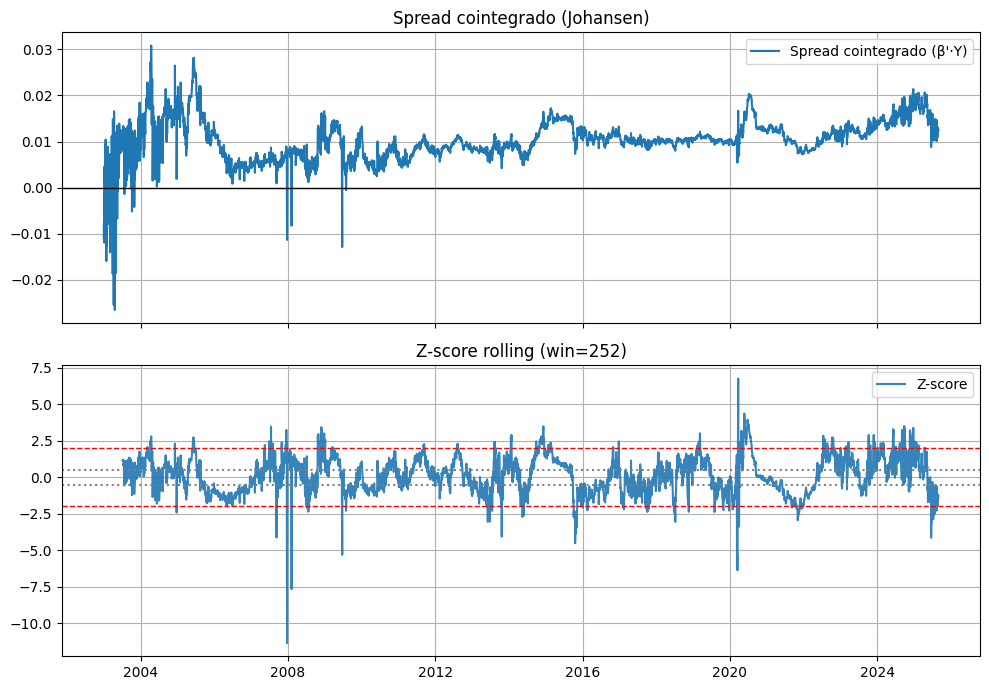


Últimas filas (spread/z-score y señales):


,Fecha,spread_ci,zscore
5503,2025-08-15,0.010125,-2.278246
5504,2025-08-19,0.013182,-1.129879
5505,2025-08-20,0.010879,-1.963059
5506,2025-08-21,0.012963,-1.184749
5507,2025-08-22,0.012525,-1.334656
5508,2025-08-25,0.011907,-1.546452
5509,2025-08-26,0.011719,-1.599550
5510,2025-08-27,0.012449,-1.322961
5511,2025-08-28,0.012259,-1.379719
5512,2025-08-29,0.012610,-1.242972



Señal actual:
  Enter LONG  (comprar spread): False
  Enter SHORT (vender  spread): False
  Exit to FLAT (cerrar): False


In [ ]:
# --- Johansen + spread estacionario + señales básicas ---

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller

# 1) Cargar datos (usa tu loader autodetect del pipeline)
df = load_tes_csv_autodetect("TES_cop_uvr.csv").dropna(subset=["TES_COP_1y","TES_COP_5y","TES_COP_10y"]).copy()

# Asegúrate de que estén ordenados por fecha
df = df.sort_values("Fecha").reset_index(drop=True)

# 2) Seleccionar las 3 series (en niveles, no diferencias)
cols = ["TES_COP_1y","TES_COP_5y","TES_COP_10y"]
Y = df[cols].values

# 3) Johansen: det_order=0 (sin constante); k_ar_diff=1 (1 rezago en diferencias)
jres = coint_johansen(Y, det_order=0, k_ar_diff=1)

# Eigenvalores y eigenvectores (columnas de evec son los β candidatos)
eigvals = jres.eig
beta_all = jres.evec   # shape (3, 3)

print("Eigenvalues:", eigvals)
print("Cointegration vectors (columns):\n", beta_all)

# 4) Elegimos el primer vector (asociado al mayor eigenvalor) y lo normalizamos:
#    Normalización: fijar el coeficiente del 10Y = 1 para interpretar el spread frente al 10Y
beta = beta_all[:, 0].copy()
beta = beta / beta[-1]  # fuerza coeficiente del 10Y a 1.0

beta_series = pd.Series(beta, index=cols)
print("\nβ normalizado (coef. TES_COP_10y = 1):\n", beta_series)

# 5) Construir el spread estacionario: s_t = β' * y_t
df["spread_ci"] = Y @ beta

# 6) Test ADF sobre el spread (debería ser I(0) si hay cointegración)
adf_stat, adf_p, _, _, crit_vals, _ = adfuller(df["spread_ci"].dropna(), autolag="AIC")
print("\nADF spread:")
print("  stat =", adf_stat, " p-value =", adf_p)
print("  critical values:", crit_vals)

# 7) Z-score rolling (para señales)
win = 252  # ~1 año hábil; ajústalo a tu preferencia (ej. 120 días)
df["spread_mean"] = df["spread_ci"].rolling(win, min_periods=win//2).mean()
df["spread_std"]  = df["spread_ci"].rolling(win, min_periods=win//2).std()
df["zscore"]      = (df["spread_ci"] - df["spread_mean"]) / df["spread_std"]

# 8) Reglas sencillas de trading (solo señal; la ejecución/PNL va aparte)
#    - z >  +2  : spread alto -> "vender spread" (corto β'·Y) ⇒ típicamente: vender 10Y vs comprar 1Y/5Y según signos de β
#    - z <  -2  : spread bajo -> "comprar spread"
#    - salida: |z| < 0.5
enter_long  =  df["zscore"] < -2.0
enter_short =  df["zscore"] >  +2.0
exit_flat   = (df["zscore"].abs() < 0.5)

# 9) Gráficas
fig, ax = plt.subplots(2, 1, figsize=(10,7), sharex=True)

ax[0].plot(df["Fecha"], df["spread_ci"], label="Spread cointegrado (β'·Y)")
ax[0].axhline(0, color="k", linewidth=1)
ax[0].set_title("Spread cointegrado (Johansen)")
ax[0].legend(); ax[0].grid(True)

ax[1].plot(df["Fecha"], df["zscore"], label="Z-score", alpha=0.9)
ax[1].axhline( 2.0, color="r", linestyle="--", linewidth=1)
ax[1].axhline(-2.0, color="r", linestyle="--", linewidth=1)
ax[1].axhline( 0.5, color="gray", linestyle=":")
ax[1].axhline(-0.5, color="gray", linestyle=":")
ax[1].set_title(f"Z-score rolling (win={win})")
ax[1].legend(); ax[1].grid(True)

plt.tight_layout()
plt.show()

# 10) Mostrar últimas señales
print("\nÚltimas filas (spread/z-score y señales):")
display(df[["Fecha","spread_ci","zscore"]].tail(10))
print("\nSeñal actual:")
print("  Enter LONG  (comprar spread):", bool(enter_long.iloc[-1]))
print("  Enter SHORT (vender  spread):", bool(enter_short.iloc[-1]))
print("  Exit to FLAT (cerrar):", bool(exit_flat.iloc[-1]))


β (normalizado, 10Y=1):


,coef
beta_1Y,0.301598
beta_5Y,-1.214370
beta_10Y,1.000000



DV01 de referencia (precio por 1bp, por 100 de nocional):


,DV01_ref
DV01_1Y,0.008902
DV01_5Y,0.032039
DV01_10Y,0.040475



Pesos DV01-neutrales cercanos a β (w):


,w (por 100 nocional)
w_1Y,0.267357
w_5Y,-1.337610
w_10Y,1.000000


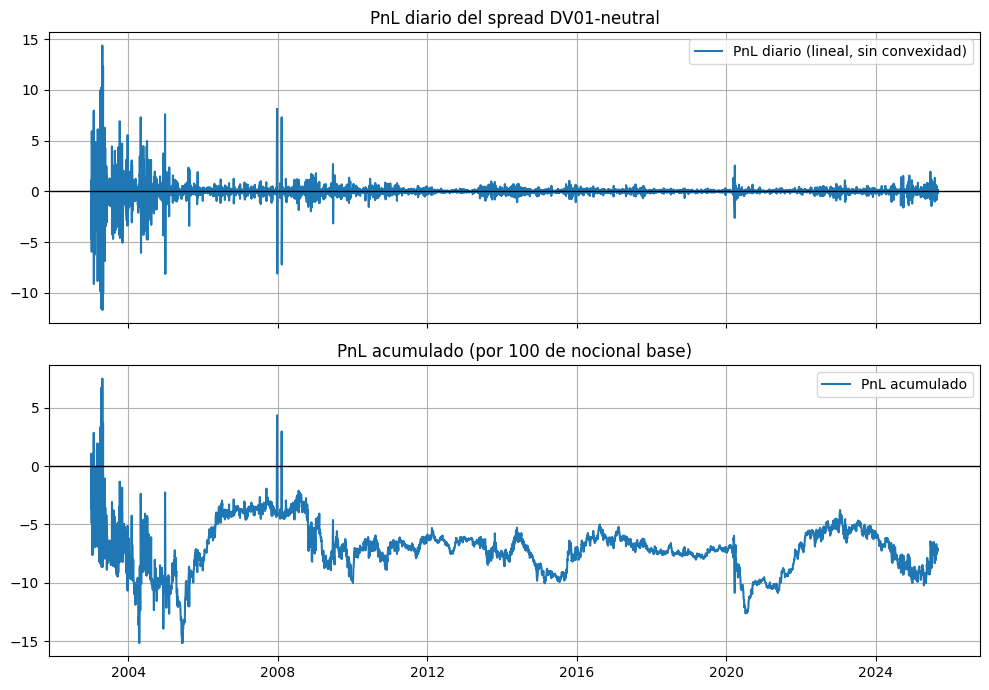


Resumen P&L:


,Fecha,pnl_1y,pnl_5y,pnl_10y,pnl_total,pnl_cum
5503,2025-08-15,0.026179,0.085711,0.121426,0.233316,-6.678248
5504,2025-08-19,-0.073777,-0.642831,-0.121426,-0.838034,-7.516283
5505,2025-08-20,0.078537,0.814252,-0.404755,0.488035,-7.028248
5506,2025-08-21,-0.071397,-0.557120,0.161902,-0.466616,-7.494863
5507,2025-08-22,0.014279,-0.085711,0.202377,0.130946,-7.363917
5508,2025-08-25,0.004760,-0.085711,0.323804,0.242853,-7.121064
5509,2025-08-26,-0.007140,-0.042855,0.161902,0.111907,-7.009158
5510,2025-08-27,-0.011900,0.042855,-0.283328,-0.252372,-7.261530
5511,2025-08-28,-0.004760,-0.299988,0.445230,0.140483,-7.121048
5512,2025-08-29,-0.011900,0.000000,-0.080951,-0.092850,-7.213898


In [ ]:
# 1) Utilidades para DV01 de un bono cero cupón con capitalización efectiva anual.
#    Tomamos precio base = 100 para tener DV01 en "precio por 1bp" por 100 de nocional.
def price_zero_from_yield(y: float, t: float) -> float:
    # P = 100 / (1 + y)^t
    return 100.0 / ((1.0 + y) ** t)

def dv01_zero_from_yield(y: float, t: float) -> float:
    # DF = (1+y)^(-t); P = 100*DF
    # dP/dy = 100 * dDF/dy = 100 * (-t) * (1+y)^(-t-1) = -100 * t * DF / (1+y)
    # DV01 = -dP/dy * 1bp = -(dP/dy) * 1e-4  -> positivo
    dfac = (1.0 + y) ** (-t)
    dP_dy = -100.0 * t * dfac / (1.0 + y)
    return -dP_dy * 1e-4  # precio por 1bp (positivo)

# 2) Función para obtener pesos w cercanos a β y DV01-neutrales:
#    min ||w - beta||^2  s.a.  [dv01]·w = 0  y  w_10Y = 1
def weights_dv01_neutral_close_to_beta(beta_vec: np.ndarray, dv01_vec: np.ndarray) -> np.ndarray:
    # beta_vec y dv01_vec son vectores de tamaño 3 en el orden [1Y, 5Y, 10Y]
    # KKT para mínimos cuadrados con restricciones de igualdad:
    # min 1/2||w - beta||^2  s.a. A w = b
    # A = [[dv01_1y, dv01_5y, dv01_10y],
    #      [0,       0,       1          ]]
    # b = [0, 1]
    A = np.array([dv01_vec, [0.0, 0.0, 1.0]], dtype=float)
    b = np.array([0.0, 1.0], dtype=float)
    I = np.eye(3)
    # Resolver el sistema KKT:
    # [I, A^T; A, 0][w; λ] = [beta; b]
    KKT = np.block([[I, A.T],
                    [A, np.zeros((2,2))]])
    rhs = np.concatenate([beta_vec, b])
    sol = np.linalg.lstsq(KKT, rhs, rcond=None)[0]
    w = sol[:3]
    return w

# 3) Construir DV01 diarios para cada tenor y convertir β -> w (DV01-neutral) fecha a fecha o usar una referencia.
#    Opción simple: usar un solo set de pesos basado en la mediana de yields (estable).
yields_mat = df[["TES_COP_1y","TES_COP_5y","TES_COP_10y"]].median().values.astype(float)
tenors = np.array([1.0, 5.0, 10.0], dtype=float)

dv01_ref = np.array([dv01_zero_from_yield(yields_mat[0], tenors[0]),
                     dv01_zero_from_yield(yields_mat[1], tenors[1]),
                     dv01_zero_from_yield(yields_mat[2], tenors[2])], dtype=float)

# 'beta' viene del bloque anterior (normalizado con 10Y=1). Asegúrate que exista:
try:
    beta  # noqa: F821
except NameError:
    # Si no existe, re-calcular rápido usando Johansen (misma lógica del bloque anterior)
    from statsmodels.tsa.vector_ar.vecm import coint_johansen
    cols = ["TES_COP_1y","TES_COP_5y","TES_COP_10y"]
    Y = df[cols].dropna().values
    jres = coint_johansen(Y, det_order=0, k_ar_diff=1)
    beta_all = jres.evec
    beta = beta_all[:, 0].copy()
    beta = beta / beta[-1]  # normaliza coef 10Y = 1

beta_vec = np.array([beta[0], beta[1], beta[2]], dtype=float)

w = weights_dv01_neutral_close_to_beta(beta_vec, dv01_ref)
w_series = pd.Series(w, index=["w_1Y","w_5Y","w_10Y"])
beta_series = pd.Series(beta_vec, index=["beta_1Y","beta_5Y","beta_10Y"])

print("β (normalizado, 10Y=1):")
display(beta_series.to_frame("coef"))
print("\nDV01 de referencia (precio por 1bp, por 100 de nocional):")
display(pd.Series(dv01_ref, index=["DV01_1Y","DV01_5Y","DV01_10Y"]).to_frame("DV01_ref"))
print("\nPesos DV01-neutrales cercanos a β (w):")
display(w_series.to_frame("w (por 100 nocional)"))

# 4) Simulación de P&L lineal por duración (sin convexidad), usando cambios de yield.
#    PnL_i ≈ - w_i * DV01_i(t-1) * Δy_i(bp)
#    Para simplicidad, usamos DV01 fijo de referencia. También puedes recalcular DV01 día a día.
df_sim = df[["Fecha","TES_COP_1y","TES_COP_5y","TES_COP_10y"]].dropna().copy()
for c in ["TES_COP_1y","TES_COP_5y","TES_COP_10y"]:
    df_sim[c+"_bp"] = df_sim[c] * 1e4  # pasar yield decimal a "basis points"

# Cambios diarios en bp
df_sim["d1y_bp"]  = df_sim["TES_COP_1y_bp"].diff()
df_sim["d5y_bp"]  = df_sim["TES_COP_5y_bp"].diff()
df_sim["d10y_bp"] = df_sim["TES_COP_10y_bp"].diff()

# P&L por leg y total (por 100 de nocional base)
# Nota de signos: si yield sube, precio baja ⇒ -DV01 * Δy_bp
df_sim["pnl_1y"]  = - w[0] * dv01_ref[0] * df_sim["d1y_bp"]
df_sim["pnl_5y"]  = - w[1] * dv01_ref[1] * df_sim["d5y_bp"]
df_sim["pnl_10y"] = - w[2] * dv01_ref[2] * df_sim["d10y_bp"]
df_sim["pnl_total"] = df_sim["pnl_1y"] + df_sim["pnl_5y"] + df_sim["pnl_10y"]

# Agregar z-score si existe de antes, y marcar entradas/salidas (opcional)
if "zscore" in df.columns:
    df_sim = df_sim.merge(df[["Fecha","zscore"]], on="Fecha", how="left")

# Cumulative P&L
df_sim["pnl_cum"] = df_sim["pnl_total"].cumsum()

# 5) Graficar
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(10,7), sharex=True)
ax[0].plot(df_sim["Fecha"], df_sim["pnl_total"], label="PnL diario (lineal, sin convexidad)")
ax[0].axhline(0, color="k", linewidth=1)
ax[0].set_title("PnL diario del spread DV01-neutral")
ax[0].legend(); ax[0].grid(True)

ax[1].plot(df_sim["Fecha"], df_sim["pnl_cum"], label="PnL acumulado")
ax[1].axhline(0, color="k", linewidth=1)
ax[1].set_title("PnL acumulado (por 100 de nocional base)")
ax[1].legend(); ax[1].grid(True)

plt.tight_layout()
plt.show()

print("\nResumen P&L:")
display(df_sim[["Fecha","pnl_1y","pnl_5y","pnl_10y","pnl_total","pnl_cum"]].tail(10))

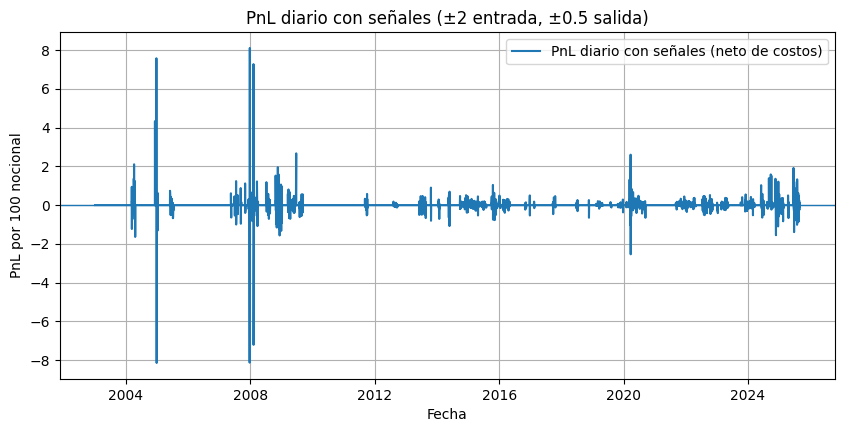

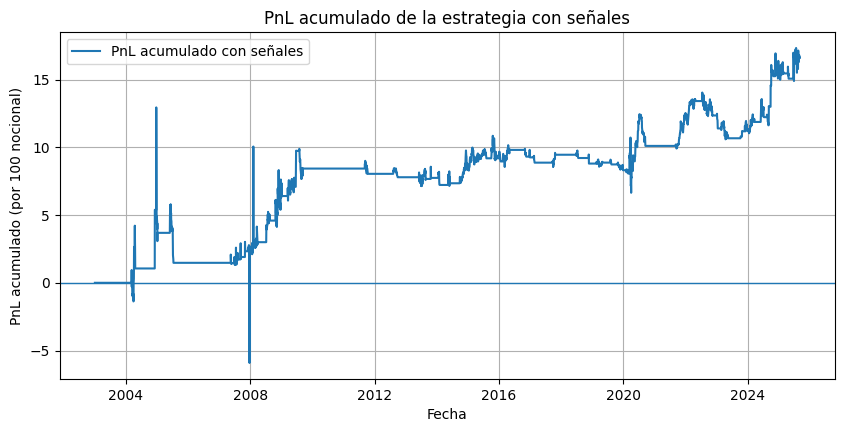

Parámetros: z_enter=2.0, z_exit=0.5, cost_bp_per_leg=0.2
Coste por cambio de posición (por 100 nocional): 0.0171
Cambios de posición (turns): 131
Días en largo: 570 | Días en corto: 989 | Días flat: 3954
PnL total (neto): 16.61
PnL anualizado ≈ (media diaria*252): 0.76
Vol anualizada ≈ (std diaria*sqrt(252)): 5.034787151165518


,Fecha,zscore,position,pnl_total,pnl_trading_net,pnl_trading_cum
5501,2025-08-13,-1.356938,1,0.623774,0.623774,16.405395
5502,2025-08-14,-1.982468,1,0.507108,0.507108,16.912503
5503,2025-08-15,-2.278246,1,0.233316,0.233316,17.145819
5504,2025-08-19,-1.129879,1,-0.838034,-0.838034,16.307785
5505,2025-08-20,-1.963059,1,0.488035,0.488035,16.795820
5506,2025-08-21,-1.184749,1,-0.466616,-0.466616,16.329204
5507,2025-08-22,-1.334656,1,0.130946,0.130946,16.460150
5508,2025-08-25,-1.546452,1,0.242853,0.242853,16.703003
5509,2025-08-26,-1.599550,1,0.111907,0.111907,16.814910
5510,2025-08-27,-1.322961,1,-0.252372,-0.252372,16.562537


In [ ]:
# Requisitos previos en memoria:
# df:  debe contener ["Fecha","zscore"] (del bloque de Johansen)
# df_sim: debe contener ["Fecha","pnl_total"] (del bloque DV01 & PnL)

# 0) Empate temporal
data = (df[["Fecha","zscore"]]
        .merge(df_sim[["Fecha","pnl_total"]], on="Fecha", how="inner")
        .sort_values("Fecha")
        .reset_index(drop=True))

# >>> OPCIONAL AGREGAR UN FILTRO DE FECHA: filtrar desde 2024-06-01
#start = pd.Timestamp("2024-06-01")
#data = data[data["Fecha"] >= start].copy()

# (opcional pero recomendable) quitar filas con NaN al inicio por ventanas rolling
#data = data.dropna(subset=["zscore", "pnl_total"]).reset_index(drop=True)

# 1) Parámetros de la estrategia
z_enter = 2.0        # entrada (|z| > 2)
z_exit  = 0.5        # salida (|z| < 0.5)
max_holding_days = None  # p.ej. 60 para límite de permanencia
cost_bp_per_leg = 0.2    # coste por leg en bps aplicable en cada cambio de posición

# 2) Si w y dv01_ref no existen, reconstruirlos de forma robusta
try:
    w
    dv01_ref
except NameError:
    def dv01_zero_from_yield(y, t):
        dfac = (1.0 + y) ** (-t)
        dP_dy = -100.0 * t * dfac / (1.0 + y)
        return -dP_dy * 1e-4

    # Medianas para DV01 de referencia
    if set(["TES_COP_1y","TES_COP_5y","TES_COP_10y"]).issubset(df.columns):
        yields_mat = df[["TES_COP_1y","TES_COP_5y","TES_COP_10y"]].median().values.astype(float)
    else:
        yields_mat = df_sim[["TES_COP_1y","TES_COP_5y","TES_COP_10y"]].median().values.astype(float)

    tenors = np.array([1.0, 5.0, 10.0], dtype=float)
    dv01_ref = np.array([dv01_zero_from_yield(yields_mat[0], tenors[0]),
                         dv01_zero_from_yield(yields_mat[1], tenors[1]),
                         dv01_zero_from_yield(yields_mat[2], tenors[2])], dtype=float)

    # Volver a obtener beta y w (mínimos cuadrados con restricciones)
    from statsmodels.tsa.vector_ar.vecm import coint_johansen
    Y = df[["TES_COP_1y","TES_COP_5y","TES_COP_10y"]].dropna().values
    jres = coint_johansen(Y, det_order=0, k_ar_diff=1)
    beta_all = jres.evec
    beta = beta_all[:,0] / beta_all[:,0][-1]
    beta_vec = np.array([beta[0], beta[1], beta[2]], dtype=float)

    A = np.array([dv01_ref, [0.0, 0.0, 1.0]], dtype=float)
    b = np.array([0.0, 1.0], dtype=float)
    I = np.eye(3)
    KKT = np.block([[I, A.T],[A, np.zeros((2,2))]])
    rhs = np.concatenate([beta_vec, b])
    sol = np.linalg.lstsq(KKT, rhs, rcond=None)[0]
    w = sol[:3]

# 3) Coste monetizado por cambio de posición (por 100 nominales)
cost_per_turn = float(np.sum(np.abs(w) * dv01_ref * cost_bp_per_leg))

# 4) Generar la serie de posiciones: -1 corto, 0 flat, +1 largo
pos = np.zeros(len(data), dtype=int)
days_in_pos = 0
for i in range(1, len(data)):
    z_now = data.loc[i, "zscore"]
    p_prev = pos[i-1]
    p_now  = p_prev

    if p_prev == 0:
        if z_now >  z_enter: p_now = -1   # z alto -> vender spread
        if z_now < -z_enter: p_now = +1   # z bajo -> comprar spread
        days_in_pos = 1 if p_now != 0 else 0
    else:
        if abs(z_now) < z_exit:
            p_now = 0
            days_in_pos = 0
        else:
            days_in_pos += 1
            if (max_holding_days is not None) and (days_in_pos >= max_holding_days):
                p_now = 0
                days_in_pos = 0
    pos[i] = p_now

data["position"] = pos

# 5) PnL condicionado por posición
#    pnl_total es el PnL de estar SIEMPRE LARGO; si estás corto, cambia el signo; si flat, es 0.
data["pnl_trading_raw"] = data["pnl_total"] * data["position"]

# 6) Costos por cambio de posición (turns). Invertir (+1 -> -1) cuenta como 2 cambios.
turns = np.abs(data["position"].diff().fillna(0))
data["cost"] = turns * cost_per_turn
data["pnl_trading_net"] = data["pnl_trading_raw"] - data["cost"]

# 7) PnL acumulado
data["pnl_trading_cum"] = data["pnl_trading_net"].cumsum()

# 8) Plots
plt.figure(figsize=(10,4.5))
plt.plot(data["Fecha"], data["pnl_trading_net"], label="PnL diario con señales (neto de costos)")
plt.axhline(0, linewidth=1)
plt.title("PnL diario con señales (±2 entrada, ±0.5 salida)")
plt.xlabel("Fecha"); plt.ylabel("PnL por 100 nocional")
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,4.5))
plt.plot(data["Fecha"], data["pnl_trading_cum"], label="PnL acumulado con señales")
plt.axhline(0, linewidth=1)
plt.title("PnL acumulado de la estrategia con señales")
plt.xlabel("Fecha"); plt.ylabel("PnL acumulado (por 100 nocional)")
plt.legend(); plt.grid(True)
plt.show()

# 9) Resumen
total_turns = int(turns.sum())
days_long  = int((data["position"]==1).sum())
days_short = int((data["position"]==-1).sum())
days_flat  = int((data["position"]==0).sum())

print(f"Parámetros: z_enter={z_enter}, z_exit={z_exit}, cost_bp_per_leg={cost_bp_per_leg}")
print(f"Coste por cambio de posición (por 100 nocional): {cost_per_turn:.4f}")
print("Cambios de posición (turns):", total_turns)
print("Días en largo:", days_long, "| Días en corto:", days_short, "| Días flat:", days_flat)
print("PnL total (neto): %.2f" % data["pnl_trading_net"].sum())
print("PnL anualizado ≈ (media diaria*252): %.2f" % (data["pnl_trading_net"].mean()*252))
print("Vol anualizada ≈ (std diaria*sqrt(252)):", float(data["pnl_trading_net"].std()*np.sqrt(252)))

# Últimas filas
display(data[["Fecha","zscore","position","pnl_total","pnl_trading_net","pnl_trading_cum"]].tail(12))